In [1]:
import os, shutil
train_dir = '../train'
validation_dir = '../validation'
test_dir = '../test'

In [2]:
from keras.utils import image_dataset_from_directory
IMG_SIZE = 32
train_dataset = image_dataset_from_directory(train_dir,label_mode='categorical',image_size=(IMG_SIZE, IMG_SIZE),batch_size=512)
validation_dataset = image_dataset_from_directory(validation_dir,label_mode='categorical',image_size=(IMG_SIZE, IMG_SIZE),batch_size=128)
test_dataset = image_dataset_from_directory(test_dir,label_mode='categorical',image_size=(IMG_SIZE, IMG_SIZE),batch_size=128)

Found 40000 files belonging to 10 classes.
Found 10000 files belonging to 10 classes.
Found 10000 files belonging to 10 classes.


In [5]:
from tensorflow import keras
from keras import layers
import tensorflow as tf

inputs = keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Flatten()(x)
x = layers.Dense(512, activation="relu")(x)
x = layers.Dense(256, activation="relu")(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(64, activation="relu")(x)
x = layers.Dense(64, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
x = layers.Dense(16, activation="relu")(x)
outputs = layers.Dense(10, activation="softmax")(x)

model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(loss='categorical_crossentropy',optimizer=tf.keras.optimizers.RMSprop(learning_rate=1e-4),metrics=['acc'])

In [6]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 32, 32, 3)         0         
                                                                 
 conv2d_7 (Conv2D)           (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 15, 15, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 6, 6, 64)          0         
 g2D)                                                      

In [7]:
history = model.fit(train_dataset,epochs=30,validation_data=validation_dataset)

Epoch 1/30
79/79 [==============================] - 10s 117ms/step - loss: 2.3614 - acc: 0.1139 - val_loss: 2.3500 - val_acc: 0.1539
Epoch 2/30
79/79 [==============================] - 9s 114ms/step - loss: 2.3341 - acc: 0.1415 - val_loss: 2.3019 - val_acc: 0.1872
Epoch 3/30
79/79 [==============================] - 9s 115ms/step - loss: 2.2878 - acc: 0.1691 - val_loss: 2.2617 - val_acc: 0.2021
Epoch 4/30
79/79 [==============================] - 9s 116ms/step - loss: 2.2419 - acc: 0.1891 - val_loss: 2.3051 - val_acc: 0.1468
Epoch 5/30
79/79 [==============================] - 10s 123ms/step - loss: 2.1913 - acc: 0.2138 - val_loss: 2.1193 - val_acc: 0.2450
Epoch 6/30
79/79 [==============================] - 9s 116ms/step - loss: 2.1389 - acc: 0.2327 - val_loss: 2.0953 - val_acc: 0.2414
Epoch 7/30
79/79 [==============================] - 9s 117ms/step - loss: 2.0940 - acc: 0.2527 - val_loss: 2.0267 - val_acc: 0.2876
Epoch 8/30
79/79 [==============================] - 9s 116ms/step - loss: 

In [8]:
val_loss, val_acc = model.evaluate(validation_dataset)
print('val_acc:', val_acc)
model.save('models/projeto_2_32.h5')

79/79 [==============================] - 1s 12ms/step - loss: 1.4142 - acc: 0.4896
val_acc: 0.4896000027656555


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


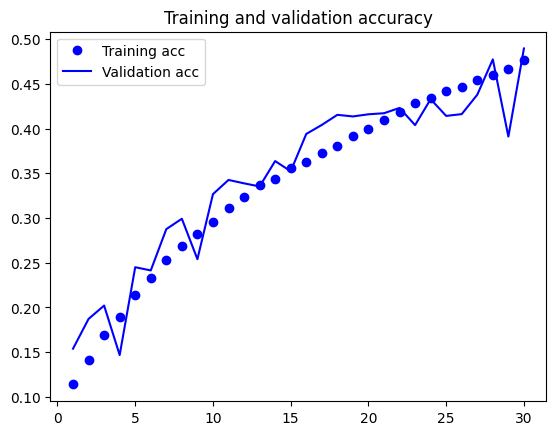

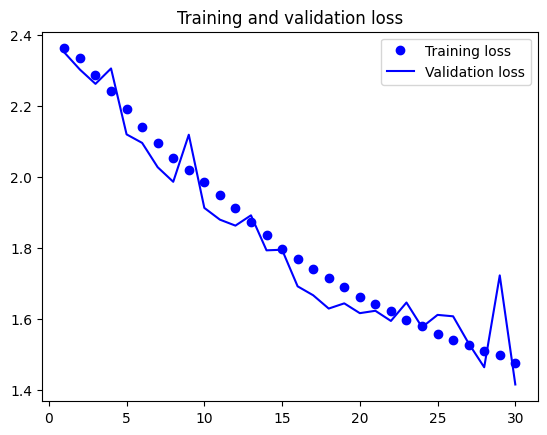

In [9]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

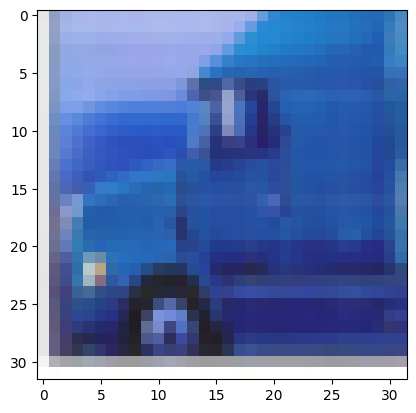

(1, 32, 32, 3)
1/1 [==============================] - 0s 65ms/step
Result: [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]
Class: 009_truck ---- Predicted Class: Automobile


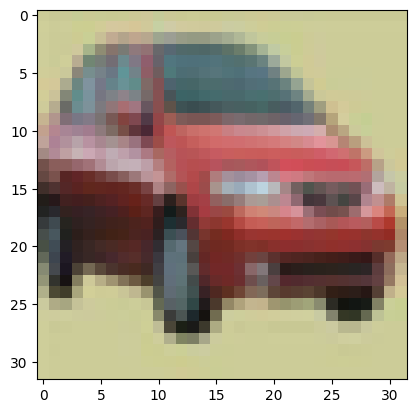

(1, 32, 32, 3)
1/1 [==============================] - 0s 14ms/step
Result: [[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]
Class: 001_automobile ---- Predicted Class: Truck


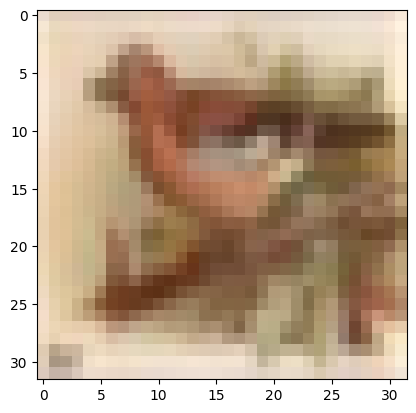

(1, 32, 32, 3)
1/1 [==============================] - 0s 15ms/step
Result: [[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]]
Class: 002_bird ---- Predicted Class: Horse


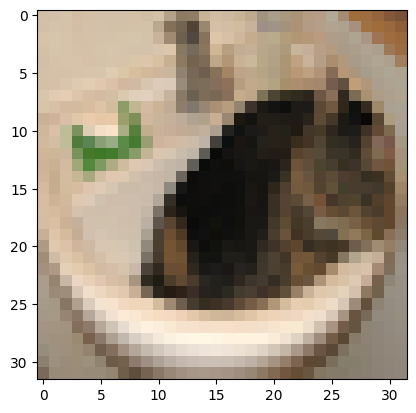

(1, 32, 32, 3)
1/1 [==============================] - 0s 13ms/step
Result: [[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]
Class: 003_cat ---- Predicted Class: Deer


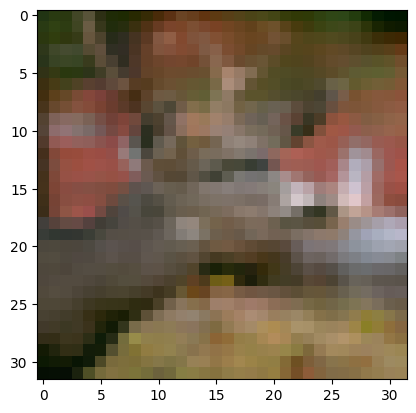

(1, 32, 32, 3)
1/1 [==============================] - 0s 14ms/step
Result: [[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]]
Class: 004_deer ---- Predicted Class: Frog


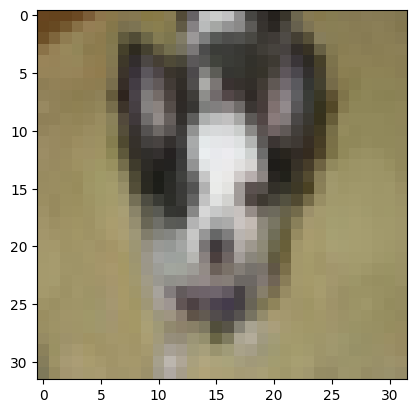

(1, 32, 32, 3)
1/1 [==============================] - 0s 21ms/step
Result: [[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]]
Class: 005_dog ---- Predicted Class: Dog


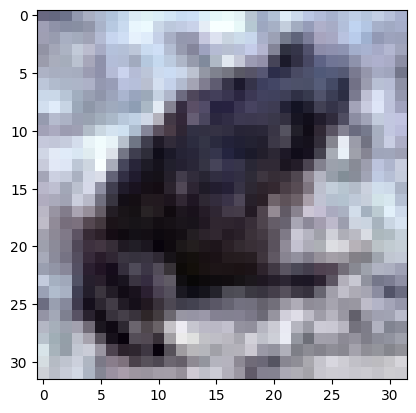

(1, 32, 32, 3)
1/1 [==============================] - 0s 14ms/step
Result: [[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]
Class: 006_frog ---- Predicted Class: Truck


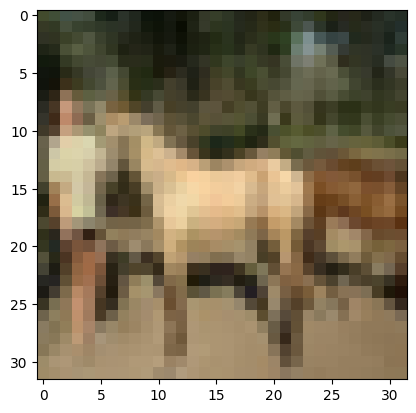

(1, 32, 32, 3)
1/1 [==============================] - 0s 20ms/step
Result: [[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]]
Class: 007_horse ---- Predicted Class: Frog


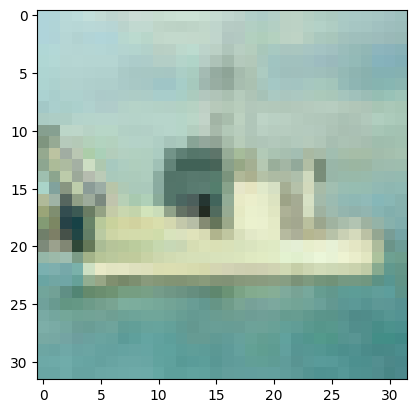

(1, 32, 32, 3)
1/1 [==============================] - 0s 15ms/step
Result: [[0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]]
Class: 008_ship ---- Predicted Class: Ship


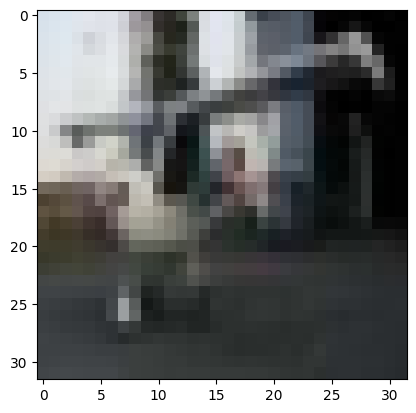

(1, 32, 32, 3)
1/1 [==============================] - 0s 16ms/step
Result: [[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]]
Class: 000_airplane ---- Predicted Class: Horse


In [13]:
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.preprocessing import image
import numpy as np
import random
from tensorflow import keras
import os
model = keras.models.load_model('models/projeto_2_32.h5')

def predict_image_class(label):
    img_path = '../train/' + label
    # Lista de classes
    classes = [f for f in os.listdir(img_path) if os.path.isfile(os.path.join(img_path, f)) and f.endswith(('.png', '.jpg', '.jpeg'))]

    random_image = random.choice(classes)
    img_path = img_path + '/' + random_image
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=(IMG_SIZE, IMG_SIZE), interpolation='bilinear')
    plt.imshow(img)
    plt.show()
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)
    print(img_array.shape)
    # Realizar a predição
    result = model.predict(img_array)

    # Obter o índice da classe com maior probabilidade
    predicted_class_index = np.argmax(result)

    # Criar um vetor de zeros do tamanho do número de classes
    predicted_vector = np.zeros_like(result)

    # Definir a classe com maior probabilidade como 1
    predicted_vector[0, predicted_class_index] = 1
    
    class_labels = {
        0: "Airplane",
        1: "Automobile",
        2: "Bird",
        3: "Cat",
        4: "Deer",
        5: "Dog",
        6: "Frog",
        7: "Horse",
        8: "Ship",
        9: "Truck"
    }

    # Obter o rótulo correspondente ao índice da classe prevista
    predicted_label = class_labels[predicted_class_index]
    print("Result:", predicted_vector)
    print("Class:", label, "---- Predicted Class:", predicted_label)
    

img = '009_truck'
predict_image_class(img)
img = '001_automobile'
predict_image_class(img)
img = '002_bird'
predict_image_class(img)
img = '003_cat'
predict_image_class(img)
img = '004_deer'
predict_image_class(img)
img = '005_dog'
predict_image_class(img)
img = '006_frog'
predict_image_class(img)
img = '007_horse'
predict_image_class(img)
img = '008_ship'
predict_image_class(img)
img = '000_airplane'
predict_image_class(img)